In [50]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

# Task 2.4 - Solving Oja's flow

First we load the data matrix

In [51]:
# load the data martix into memory
X = np.loadtxt("GaussianSample3D.csv", delimiter=', ')
# check it's dimensionality
X.shape

(3, 250)

Next we build the sample covariance matrix. Note that the data matrix is already normalized, i.e. it has zero mean.

In [52]:
# build the sample covariance matrix
C = 1/X.shape[1] * (X @ X.T)

Now we can compute the spectral decomposition of the covatiance matrix. Remeber from the last assignment sheet we observed that `la.eigh` is a good choice for this task, since the covariance matrix is symmetric.

In [67]:
# compute the spectral decompostion of the covariance matrix
# V_eig: eigenvalues of C in ascending order
# U_eig: eigenvectors of C
V_eig, U_eig = la.eigh(C)
# show the eigenvector corresponding to the largest eigenvalue
# remember the ascending order of the eigenvalues
U_eig[:, -1]

$u_1$ [ 0.7988784  -0.50319912 -0.32952077]


Approximate the leading eigenvector using Oja's flow by solving the differential equation 

$$ \dot w = (I - ww^T)Cw $$

In [66]:
from scipy.integrate import odeint
# implement the differential equation
w_prime = lambda w, t: (np.eye(3) - w[:, None] @ w[None, :]) @ C @ w
# create a random unit vector as an initial guess
# note that the probablity distribtion from which we sample
# is NOT uniform over the boundary over the unit sphere
w_0 = np.random.uniform(-1, 1, size=(3,))
w_0 /= la.norm(w_0)
# solve the differential equation using scipy's odeint method
t = np.linspace(0, 3, 50)
w = odeint(w_prime, w_0, t)
# print approximation of u_1
w[-1, :]

array([ 0.79885363, -0.50324345, -0.32951316])

Visualize the results

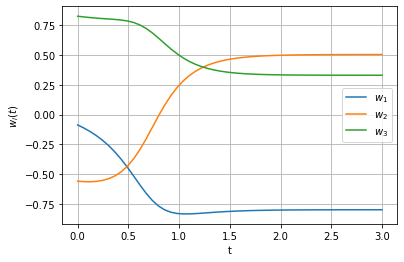

In [63]:
# plot the course of the three vector-components over time
fig, ax = plt.subplots(1, 1)
ax.set(xlabel="t", ylabel="$w_i(t)$")
ax.grid()
ax.plot(t, w)
ax.legend(["$w_1$", "$w_2$", "$w_3$"])
fig.savefig("OjaFlow.png")
plt.show()

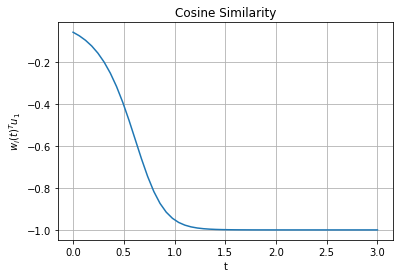

In [64]:
# plot the cosine similarity between the
# approximation and the target over time
fig, ax = plt.subplots(1, 1)
ax.set(title="Cosine Similarity", xlabel="t", ylabel="$w_i(t)^Tu_1$")
ax.grid()
ax.plot(t, w @ U_eig[:, -1])
fig.savefig("CosSimilarity.png")
plt.show()

One can see that in fact the solution $w^*$ to the differential equation is the leading eigenvector $u_1$ of the sample covariance matrix $C$. Depending on the initial condition for the flow it might happen that the the two vectors are of different sign, i.e. $w^* = -u_1$. This is represented by the cosine similarity converging to -1 instead of +1. However $w^* = -u_1$ is still a leading eigenvector of $C$.

To get a bit more precise one can observe that the cosine similarity between the iterative approximations $w_i$ and the target $u_1$ never crosses the x-axes. What does this mean? Consider the plane for which $u_1$ is the normal vector. Then all the $w_i$ will be on the same side of the plane. This includes not just the randomly chosen initial condition $w_0$ but also the vector of convergence. Thus we see the following condition:

$$ w^* = sgn(w_0^Tu_1)u_1 $$

## Task 2.6 - Sorting with QR Algorithm

In [57]:
def qr_alg(A:np.ndarray, k:int =10) -> np.ndarray:
    # iterate for k iterations
    for _ in range(k):
        # decompose and build next matrix
        Q, R = la.qr(A)
        A = R @ Q
    # return last
    return A
def qr_sort(x:np.ndarray, eps:float =1e-4, **kwargs) -> np.ndarray:
    # get the dimension of the input vector
    n = x.shape[0]
    # build the tri-diagonal matrix with the vector x on the main
    # diagonal and eps on both off-diagonals
    off_diag = [eps] * (n-1)
    X = np.diag(x) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)
    # compute the matrix exponential
    X_prime = la.expm(X)
    # apply the qr-algorithm
    Y_prime = qr_alg(X_prime, **kwargs)
    # compute the matrix logarithm
    Y = la.logm(Y_prime)
    # return the diagonal entries
    return np.diag(Y)

In [58]:
# create some sample input
x = np.asarray([4, -3, 2, 7, 12, 1], dtype=np.float32)
# apply for different iterations of the qr algorithm
for k in [1, 5, 10, 50]:
    sorted_x = qr_sort(x, k=k)
    sorted_x = np.rint(sorted_x)
    print("k=%i:\t" % k, sorted_x)

k=1:	 [ 4. -3.  2.  7. 12.  1.]
k=5:	 [ 4. 12.  7.  2. -3.  1.]
k=10:	 [12.  4.  7.  2. -3.  1.]
k=50:	 [12.  7.  4.  2.  1. -3.]
